In [185]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 1. Exploratory Data Analysis (EDA)

In [186]:
df = pd.read_csv(r'C:\Users\hafeez_poldz\Desktop\Thinkful\Unit 1\Datas\Welcome\WELLCOME_APCspend2013_forThinkful.csv', 
                 encoding  = 'ISO-8859-1')
df.head()

,PMID/PMCID,Publisher,Journal title,Article title,COST (£) charged to Wellcome (inc VAT when charged)
0,NaN,CUP,Psychological Medicine,Reduced parahippocampal cortical thickness in ...,£0.00
1,PMC3679557,ACS,Biomacromolecules,Structural characterization of a Model Gram-ne...,£2381.04
2,23043264 PMC3506128,ACS,J Med Chem,"Fumaroylamino-4,5-epoxymorphinans and related ...",£642.56
3,23438330 PMC3646402,ACS,J Med Chem,Orvinols with mixed kappa/mu opioid receptor a...,£669.64
4,23438216 PMC3601604,ACS,J Org Chem,Regioselective opening of myo-inositol orthoes...,£685.88


In [187]:
print(df.isnull().sum())
print(df.info())

PMID/PMCID                                             199
Publisher                                                0
Journal title                                            1
Article title                                            0
COST (£) charged to Wellcome (inc VAT when charged)      0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2127 entries, 0 to 2126
Data columns (total 5 columns):
PMID/PMCID                                             1928 non-null object
Publisher                                              2127 non-null object
Journal title                                          2126 non-null object
Article title                                          2127 non-null object
COST (£) charged to Wellcome (inc VAT when charged)    2127 non-null object
dtypes: object(5)
memory usage: 83.2+ KB
None


Our dataset has 2127 rows and 5 columns entitled:
    - PMID/PMCID: PubMed ID
    - Publisher: The name of the publisher, as reported by the instituion
    - Journal title: The name of journal
    - Article title: The title of the article 
    - COST (£) charged to Wellcome (inc VAT when charged: Publishing fee

In general, 2127 articles are devoted to Welcome Trust. If we look at Journal title and Article title columns, we can see that the the total number of articles per journal also represents the popularity the journal.

# 2. Data Cleaning & Manipulation
The data type of all columns is object. To make some calculation, we need to clean the data and manipulate it. 

In [188]:
# standartize the Journal titles 
df['Journal title'] = df['Journal title'].str.lower()
df['Journal title'] = df['Journal title'].str.replace('and', '&')
df['Journal title'] = df['Journal title'].str.replace('for', 'of')
df['Journal title'] = df['Journal title'].str.replace('.', '')
df['Journal title'] = df['Journal title'].str.replace('plosone', 'plos one')
df['Journal title'] = df['Journal title'].str.replace('development', 'developmental')
df['Journal title'] = df['Journal title'].str.replace('behaviour', 'behavior')
df['Journal title'] = df['Journal title'].str.replace('jnl', 'journal')
df['Journal title'] = df['Journal title'].str.rstrip()
df.rename(columns = {'COST (£) charged to Wellcome (inc VAT when charged)':'Cost'}, inplace = True)

df['PMID/PMCID'].drop_duplicates(inplace = True)
#df['Journal title'].value_counts().head()
total_articles = df.groupby('Journal title')['Article title'].count().sort_values(ascending = False)
total_articles.head()

Journal title
plos one                           199
journal of biological chemistry     53
neuroimage                          29
nucleic acids research              26
plos pathogens                      24
Name: Article title, dtype: int64

Seems the most common journal is Plos One which has devoted 199 articles to Welcome Trust. Now we need to calculate mean, median and standard deviation of the open-access cost per article for each journal. Before we need to clean the Cost column.

In [189]:
print(df.Cost.dtype)

# check for other currencies except '£'
for currency in df.Cost:
    if currency[0] !='£':
        print(currency)

object
1674$
1375.8$
2010$
1204.38$
1254.6$
1476$
671.04$
1440$
1460.3$
1476.47$
1570.87$
1600.25$
1600.25$


In [190]:
"""we can convert $ to £ using the average rate for the GBP/USD currency conversion on 31 December 2013 (31/12/2013)"""   
# converted = []
# for symbol in df.Cost.str[:]:
#    if symbol[0] != '£':
#        converted.append(float(symbol.replace('$',''))/1.6528)
#    else:
#        converted.append(float(symbol.replace('£','')))
# df.Cost = converted

'we can convert $ to £ using the average rate for the GBP/USD currency conversion on 31 December 2013 (31/12/2013)'

In [191]:
# remove £ and $ signs from Cost columns
df['Cost'] = df['Cost'].str.replace('£', '')
df['Cost'] = df['Cost'].str.replace('$', '')

# df.Cost.apply(lambda x: x.replace('£',''))
# df.Cost.apply(lambda x: x.replace('$',''))

In [192]:
df.Cost.head()

0       0.00
1    2381.04
2     642.56
3     669.64
4     685.88
Name: Cost, dtype: object

In [197]:
# convert Cost column to float
df['Cost'] = df['Cost'].astype(float)

                Cost
count    2127.000000
mean    24067.339972
std    146860.665559
min         0.000000
5%        736.205000
25%      1280.000000
50%      1884.010000
75%      2321.305000
95%      3780.000000
100%   999999.000000
max    999999.000000


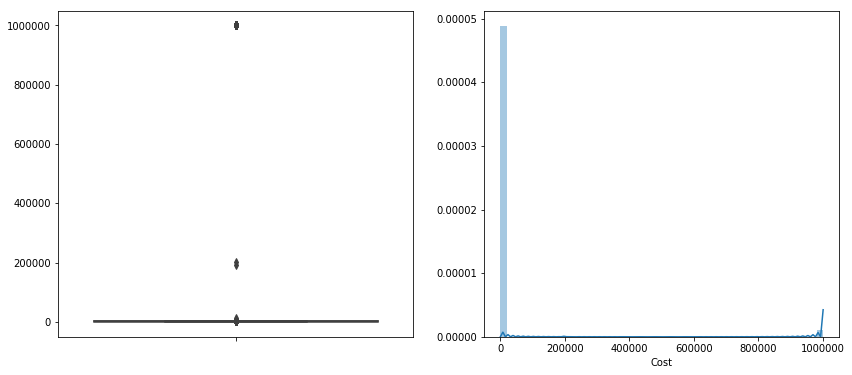

In [198]:
# check for outliers
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (14,6))
_ = sns.boxplot(y = ['Cost'], data = df, ax = ax1)
_ = sns.distplot(df['Cost'], ax = ax2)
print(df.describe(percentiles = [0.05, .25, 0.5, 0.75, 0.95, 1]))

Boxplot shows that our data has few extreme outliers. We'll use winsorizing method to remove outliers for further calculations. It will reduce the influnce of the outliers to our end results. Our strategy is to set all outliers to a specified percentile of the data.

In [199]:
# calculate 5th and 95th percentiles
p = np.percentile(df['Cost'], [5, 95])

# filter Cost columns from outliers
new_df = df[(df['Cost'] > p[0]) & (df['Cost'] < p[1])]
new_df.describe(percentiles = [.05, 0.25, 0.5, 0.75, 0.95, 1])


,Cost
count,1910.000000
mean,1824.256241
std,615.393518
min,741.350000
5%,850.000000
25%,1331.885000
50%,1882.970000
75%,2291.302500
95%,2925.339000
100%,3750.050000


              Cost
count  1910.000000
mean   1824.256241
std     615.393518
min     741.350000
5%      850.000000
25%    1331.885000
50%    1882.970000
75%    2291.302500
95%    2925.339000
100%   3750.050000
max    3750.050000


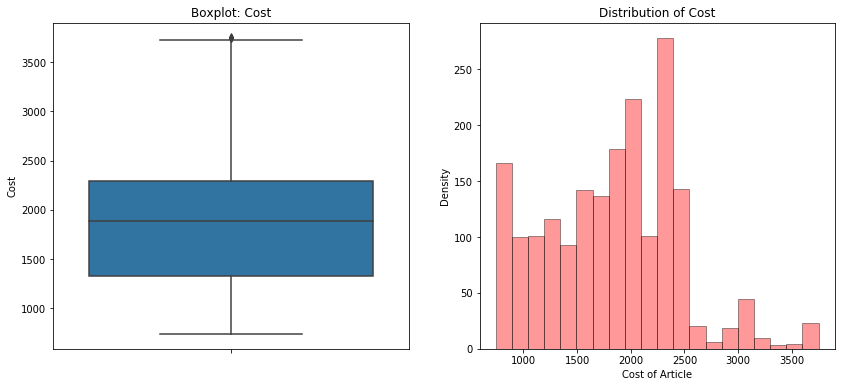

In [200]:
# check for outliers
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (14,6))
_ = sns.boxplot(y = ['Cost'], data = new_df, ax = ax1)
_.set(ylabel = 'Cost', title = 'Boxplot: Cost')
_ = sns.distplot(new_df['Cost'], hist = True, kde = False, ax = ax2, color = 'r', hist_kws={'edgecolor':'black'}, bins = 20)
_.set(xlabel = 'Cost of Article', ylabel = 'Density', title = 'Distribution of Cost')
print(new_df.describe(percentiles = [0.05, .25, 0.5, 0.75, 0.95, 1]))

Now we removed outliers and our data is cleaner and ready for calculation.

# 3. Mean, Median & Standard Deviation

In [201]:
# calculate mean, median and standard deviation for each journal
agg_cost_per_article = new_df.groupby('Journal title')['Cost'].agg(['mean', 'median', 'std','count']).round().sort_values(
    by = 'count', ascending = False)
agg_cost_per_article.head()

,mean,median,std,count
Journal title,,,,
plos one,954.0,897.0,163.0,183
journal of biological chemistry,1446.0,1315.0,382.0,51
neuroimage,2215.0,2326.0,267.0,29
nucleic acids research,1167.0,852.0,443.0,25
plos genetics,1643.0,1713.0,153.0,22


After removing outliers from the data, the total number of articles per most common journals is changed. Now we can conclude that the most common Journal is 'Plos One' followed by 'Journal of Biological Chemistry'. Plos One also is reasonably cheaper than other most common journals.